# Task 2: Sentiment and Thematic Analysis

## Objective
Quantify review sentiment and identify themes to uncover satisfaction drivers and pain points.

**Components:**
1. **Sentiment Analysis** - Classify reviews as Positive/Negative/Neutral
   - VADER (rule-based, fast)
   - DistilBERT (transformer-based, accurate)
2. **Thematic Analysis** - Extract themes from reviews
   - TF-IDF keyword extraction
   - Theme mapping to business categories

## 1. Setup and Imports

In [1]:
# Add src directory to path
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Project imports
from config import DATA_PATHS, THEME_KEYWORDS, BANK_NAMES
from sentiment_analyzer import SentimentAnalyzer
from theme_analyzer import ThemeAnalyzer

# Display settings
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Create output directory
os.makedirs('../data/processed', exist_ok=True)

print("Setup complete!")

c:\Users\filimon.hailemariam\Downloads\Google-Play-Store-Reviews\Google-Play-Store-Reviews\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete!


## 2. Load Processed Reviews

In [2]:
# Load the preprocessed reviews from Task 1
df = pd.read_csv('../data/processed/reviews_processed.csv')

print(f"Loaded {len(df)} reviews")
print(f"\nReviews per bank:")
print(df['bank_name'].value_counts())
print(f"\nColumns: {list(df.columns)}")

Loaded 7290 reviews

Reviews per bank:
bank_name
Commercial Bank of Ethiopia    5697
Bank of Abyssinia               952
Dashen Bank                     641
Name: count, dtype: int64

Columns: ['review_id', 'review_text', 'rating', 'review_date', 'review_year', 'review_month', 'bank_code', 'bank_name', 'user_name', 'thumbs_up', 'text_length', 'source']


In [3]:
# Preview the data
df.head()

,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,7ef21cf6-d226-4370-ab96-01c909dbc58d,very good,5,2025-11-25,2025,11,BOA,Bank of Abyssinia,lij gech,0,9,Google Play
1,896ee9aa-a483-4b1f-b73c-0a26c4b54790,most of the time is not working properly,1,2025-11-25,2025,11,BOA,Bank of Abyssinia,ashenafi endale,0,40,Google Play
2,15c3586b-e672-48db-b3c0-09508375763f,good service,5,2025-11-25,2025,11,BOA,Bank of Abyssinia,Muluberhan Berhane,0,12,Google Play
3,6f7113d8-180e-4f3d-83d9-fbe55f9edd69,not use for me,3,2025-11-23,2025,11,BOA,Bank of Abyssinia,Kemal Mahmud,0,14,Google Play
4,d36fbdcb-b57e-4384-8e5b-ae549e25b33e,It keeps notifying me to disable developer options and quiet while I'm not enabled. always bring...,1,2025-11-22,2025,11,BOA,Bank of Abyssinia,Eyosias Adane,0,138,Google Play


## 3. Sentiment Analysis

We'll use two methods and compare their results:
1. **VADER** - Fast, rule-based, good for social media text
2. **DistilBERT** - Deep learning, understands context, more accurate

### 3.1 VADER Sentiment Analysis

In [4]:
# Initialize VADER analyzer
vader_analyzer = SentimentAnalyzer(method='vader')

# Analyze all reviews
df_vader = vader_analyzer.analyze_dataframe(df)

Initializing VADER sentiment analyzer...
VADER ready!

Analyzing sentiment for 7290 reviews using VADER...


Analyzing: 100%|██████████| 7290/7290 [00:00<00:00, 18355.33it/s]



SENTIMENT ANALYSIS SUMMARY

Overall Sentiment Distribution (VADER):
  POSITIVE: 4157 (57.0%)
  NEUTRAL: 2017 (27.7%)
  NEGATIVE: 1116 (15.3%)

Sentiment by Bank:
  Bank of Abyssinia:
    Positive: 42.1% | Negative: 28.4%
  Commercial Bank of Ethiopia:
    Positive: 58.2% | Negative: 13.6%
  Dashen Bank:
    Positive: 69.0% | Negative: 10.9%


In [5]:
# VADER results preview
df_vader[['review_text', 'rating', 'sentiment_label_vader', 'sentiment_score_vader']].head(10)

,review_text,rating,sentiment_label_vader,sentiment_score_vader
0,very good,5,POSITIVE,0.4927
1,most of the time is not working properly,1,NEUTRAL,0.0000
2,good service,5,POSITIVE,0.4404
3,not use for me,3,NEUTRAL,0.0000
4,It keeps notifying me to disable developer options and quiet while I'm not enabled. always bring...,1,NEGATIVE,0.4019
5,waw,5,NEUTRAL,0.0000
6,the lag is unbelievable when you need it the most this suks,1,NEGATIVE,0.1531
7,I cant belive I could find the worst bank app ever .yet very simple to fix the problem and the c...,1,NEGATIVE,0.8834
8,it is a good app,5,POSITIVE,0.4404
9,it is not working at all,1,NEUTRAL,0.0000


### 3.2 DistilBERT Sentiment Analysis

**Note:** This will take longer than VADER (a few minutes for 1000+ reviews). The model will be downloaded on first run (~250MB).

In [6]:
# Initialize DistilBERT analyzer
distilbert_analyzer = SentimentAnalyzer(method='distilbert')

# Analyze all reviews (this takes longer)
df_sentiment = distilbert_analyzer.analyze_dataframe(df_vader)

Initializing DistilBERT sentiment analyzer...
(This may take a moment to download the model on first run)
Using CPU for inference


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu


DistilBERT ready!

Analyzing sentiment for 7290 reviews using DISTILBERT...


Analyzing: 100%|██████████| 7290/7290 [05:09<00:00, 23.53it/s]


SENTIMENT ANALYSIS SUMMARY

Overall Sentiment Distribution (DISTILBERT):
  POSITIVE: 4199 (57.6%)
  NEGATIVE: 3091 (42.4%)

Sentiment by Bank:
  Bank of Abyssinia:
    Positive: 38.1% | Negative: 61.9%
  Commercial Bank of Ethiopia:
    Positive: 59.5% | Negative: 40.5%
  Dashen Bank:
    Positive: 70.0% | Negative: 30.0%


In [7]:
# DistilBERT results preview
df_sentiment[['review_text', 'rating', 'sentiment_label_vader', 'sentiment_label_distilbert']].head(10)

,review_text,rating,sentiment_label_vader,sentiment_label_distilbert
0,very good,5,POSITIVE,POSITIVE
1,most of the time is not working properly,1,NEUTRAL,NEGATIVE
2,good service,5,POSITIVE,POSITIVE
3,not use for me,3,NEUTRAL,NEGATIVE
4,It keeps notifying me to disable developer options and quiet while I'm not enabled. always bring...,1,NEGATIVE,NEGATIVE
5,waw,5,NEUTRAL,NEGATIVE
6,the lag is unbelievable when you need it the most this suks,1,NEGATIVE,NEGATIVE
7,I cant belive I could find the worst bank app ever .yet very simple to fix the problem and the c...,1,NEGATIVE,NEGATIVE
8,it is a good app,5,POSITIVE,POSITIVE
9,it is not working at all,1,NEUTRAL,NEGATIVE


### 3.3 Compare VADER vs DistilBERT

In [8]:
# Agreement rate between the two methods
agreement = (df_sentiment['sentiment_label_vader'] == df_sentiment['sentiment_label_distilbert']).mean()
print(f"Agreement rate: {agreement * 100:.1f}%")

# Confusion matrix
print("\nCross-tabulation (VADER vs DistilBERT):")
pd.crosstab(df_sentiment['sentiment_label_vader'], 
            df_sentiment['sentiment_label_distilbert'], 
            margins=True)

Agreement rate: 61.1%

Cross-tabulation (VADER vs DistilBERT):


sentiment_label_distilbert,NEGATIVE,POSITIVE,All
sentiment_label_vader,,,
NEGATIVE,1094,22,1116
NEUTRAL,1200,817,2017
POSITIVE,797,3360,4157
All,3091,4199,7290


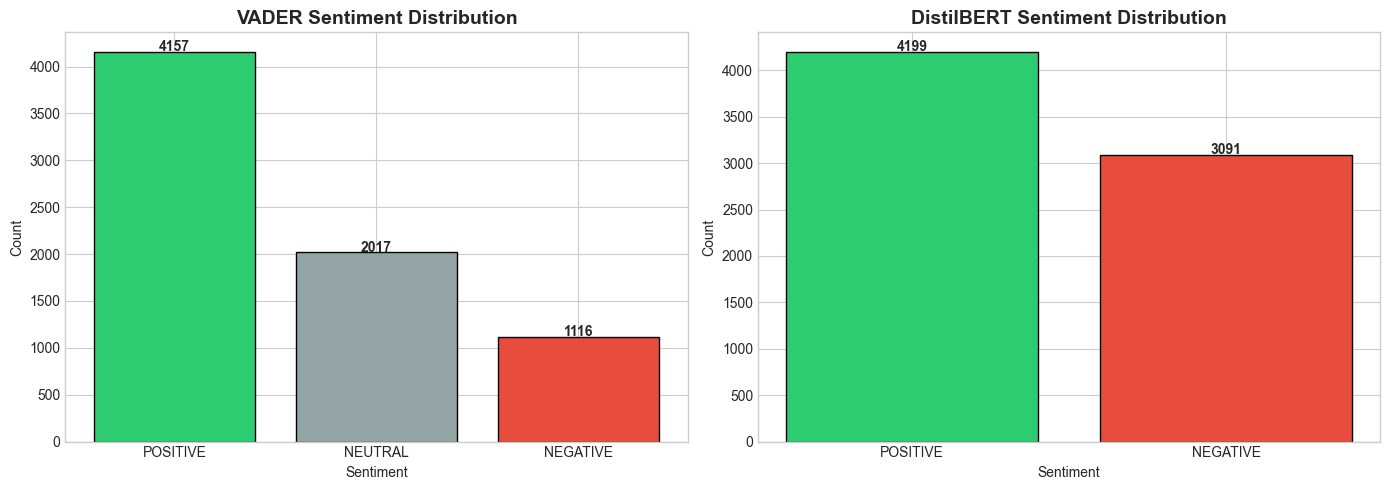

In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VADER distribution
ax1 = axes[0]
vader_counts = df_sentiment['sentiment_label_vader'].value_counts()
colors = {'POSITIVE': '#2ecc71', 'NEGATIVE': '#e74c3c', 'NEUTRAL': '#95a5a6'}
ax1.bar(vader_counts.index, vader_counts.values, 
        color=[colors.get(x, '#333') for x in vader_counts.index], edgecolor='black')
ax1.set_title('VADER Sentiment Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
for i, (label, count) in enumerate(vader_counts.items()):
    ax1.text(i, count + 10, str(count), ha='center', fontweight='bold')

# DistilBERT distribution
ax2 = axes[1]
distilbert_counts = df_sentiment['sentiment_label_distilbert'].value_counts()
ax2.bar(distilbert_counts.index, distilbert_counts.values,
        color=[colors.get(x, '#333') for x in distilbert_counts.index], edgecolor='black')
ax2.set_title('DistilBERT Sentiment Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Count')
for i, (label, count) in enumerate(distilbert_counts.items()):
    ax2.text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/sentiment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.4 Sentiment by Bank

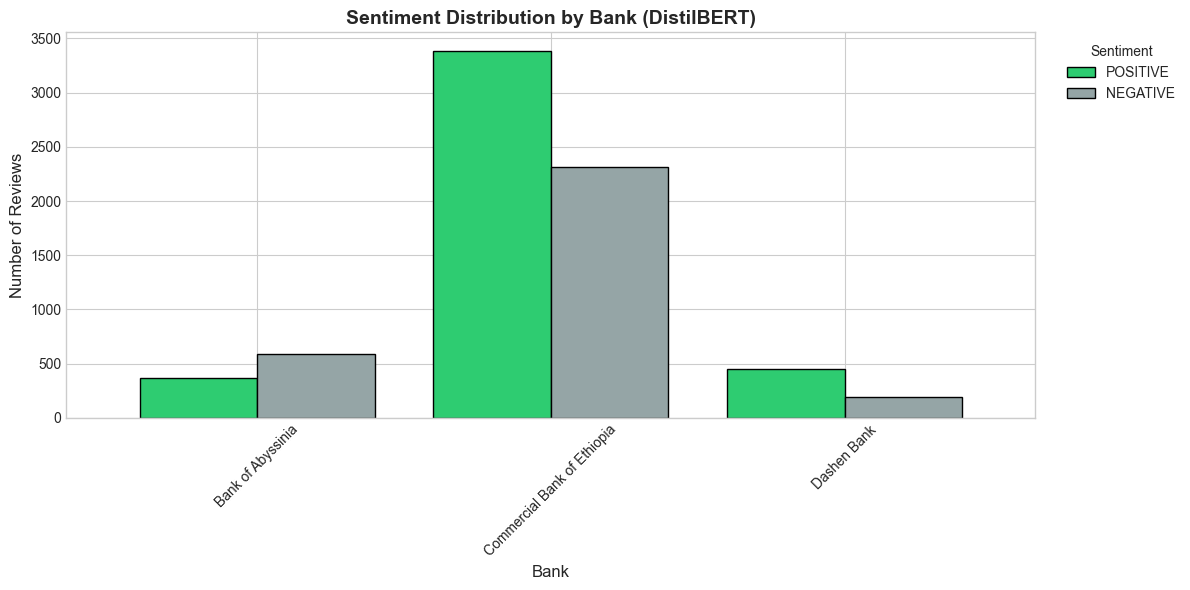

In [10]:
# Sentiment distribution by bank (using DistilBERT as primary)
fig, ax = plt.subplots(figsize=(12, 6))

sentiment_by_bank = df_sentiment.groupby(['bank_name', 'sentiment_label_distilbert']).size().unstack(fill_value=0)

# Reorder columns
col_order = ['POSITIVE', 'NEUTRAL', 'NEGATIVE'] if 'NEUTRAL' in sentiment_by_bank.columns else ['POSITIVE', 'NEGATIVE']
sentiment_by_bank = sentiment_by_bank[[c for c in col_order if c in sentiment_by_bank.columns]]

sentiment_by_bank.plot(kind='bar', ax=ax, color=['#2ecc71', '#95a5a6', '#e74c3c'][:len(sentiment_by_bank.columns)], 
                       edgecolor='black', width=0.8)

ax.set_title('Sentiment Distribution by Bank (DistilBERT)', fontsize=14, fontweight='bold')
ax.set_xlabel('Bank', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/processed/sentiment_by_bank.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Sentiment percentage by bank
print("Sentiment Percentage by Bank (DistilBERT):")
print("=" * 60)

for bank in df_sentiment['bank_name'].unique():
    bank_df = df_sentiment[df_sentiment['bank_name'] == bank]
    total = len(bank_df)
    pos = len(bank_df[bank_df['sentiment_label_distilbert'] == 'POSITIVE'])
    neg = len(bank_df[bank_df['sentiment_label_distilbert'] == 'NEGATIVE'])
    
    print(f"\n{bank}:")
    print(f"  Positive: {pos} ({pos/total*100:.1f}%)")
    print(f"  Negative: {neg} ({neg/total*100:.1f}%)")
    print(f"  Satisfaction Score: {pos/total*100:.1f}%")

Sentiment Percentage by Bank (DistilBERT):

Bank of Abyssinia:
  Positive: 363 (38.1%)
  Negative: 589 (61.9%)
  Satisfaction Score: 38.1%

Commercial Bank of Ethiopia:
  Positive: 3387 (59.5%)
  Negative: 2310 (40.5%)
  Satisfaction Score: 59.5%

Dashen Bank:
  Positive: 449 (70.0%)
  Negative: 192 (30.0%)
  Satisfaction Score: 70.0%


### 3.5 Sentiment vs Rating Correlation

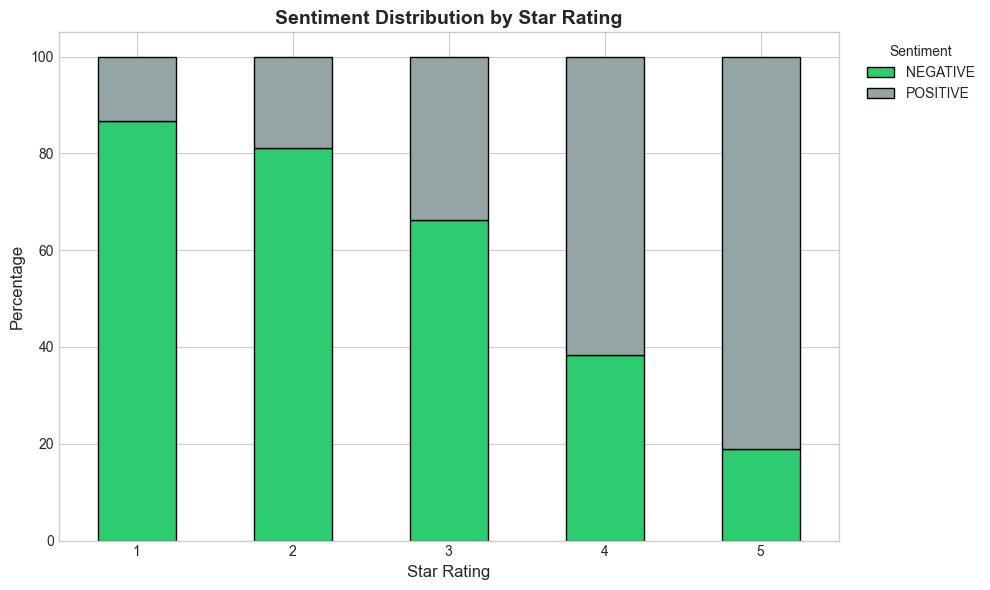


Observation: We expect 1-2 star reviews to be mostly NEGATIVE,
and 4-5 star reviews to be mostly POSITIVE.


In [12]:
# How well does sentiment match the star rating?
fig, ax = plt.subplots(figsize=(10, 6))

# Group by rating and sentiment
rating_sentiment = df_sentiment.groupby(['rating', 'sentiment_label_distilbert']).size().unstack(fill_value=0)

# Normalize to percentages
rating_sentiment_pct = rating_sentiment.div(rating_sentiment.sum(axis=1), axis=0) * 100

rating_sentiment_pct.plot(kind='bar', stacked=True, ax=ax, 
                          color=['#2ecc71', '#95a5a6', '#e74c3c'][:len(rating_sentiment_pct.columns)],
                          edgecolor='black')

ax.set_title('Sentiment Distribution by Star Rating', fontsize=14, fontweight='bold')
ax.set_xlabel('Star Rating', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../data/processed/sentiment_vs_rating.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nObservation: We expect 1-2 star reviews to be mostly NEGATIVE,")
print("and 4-5 star reviews to be mostly POSITIVE.")

## 4. Thematic Analysis

Now we'll identify WHAT users are talking about using:
- TF-IDF keyword extraction
- Mapping to predefined business themes

In [13]:
# Show predefined themes
print("Predefined Themes and Keywords:")
print("=" * 60)
for theme, keywords in THEME_KEYWORDS.items():
    print(f"\n{theme}:")
    print(f"  Keywords: {', '.join(keywords[:5])}...")

Predefined Themes and Keywords:

Account Access Issues:
  Keywords: login, password, authentication, forgot, reset...

Transaction Performance:
  Keywords: transfer, slow, fast, speed, loading...

User Interface & Experience:
  Keywords: ui, interface, design, layout, navigation...

Technical Issues:
  Keywords: crash, bug, error, freeze, hang...

Customer Support:
  Keywords: support, help, service, response, contact...

Feature Requests:
  Keywords: feature, add, need, want, wish...

Security & Privacy:
  Keywords: security, safe, secure, privacy, fingerprint...


In [14]:
# Initialize theme analyzer
theme_analyzer = ThemeAnalyzer()

# Analyze themes
df_final = theme_analyzer.analyze_dataframe(df_sentiment)

Initializing TF-IDF vectorizer...
TF-IDF ready!
Loading spaCy model...
spaCy ready!

Analyzing themes for 7290 reviews...

[1/2] Extracting keywords using TF-IDF...
[2/2] Mapping keywords to themes...


Identifying themes: 100%|██████████| 7290/7290 [00:00<00:00, 63049.87it/s]


THEMATIC ANALYSIS SUMMARY

Overall Theme Distribution:
  Transaction Performance: 1113 reviews (15.3%)
  Technical Issues: 829 reviews (11.4%)
  User Interface & Experience: 796 reviews (10.9%)
  Feature Requests: 778 reviews (10.7%)
  Customer Support: 498 reviews (6.8%)
  Account Access Issues: 438 reviews (6.0%)
  Security & Privacy: 276 reviews (3.8%)

  Reviews with no identified theme: 4334 (59.5%)

Top Theme by Bank:
  Bank of Abyssinia: Technical Issues (174 mentions)
  Commercial Bank of Ethiopia: Transaction Performance (835 mentions)
  Dashen Bank: Transaction Performance (145 mentions)


In [15]:
# Preview theme results
df_final[['review_text', 'primary_theme', 'themes', 'matched_keywords']].head(10)

,review_text,primary_theme,themes,matched_keywords
0,very good,Other,[],[]
1,most of the time is not working properly,Technical Issues,[Technical Issues],[not working]
2,good service,Customer Support,[Customer Support],[service]
3,not use for me,Other,[],[]
4,It keeps notifying me to disable developer options and quiet while I'm not enabled. always bring...,User Interface & Experience,"[User Interface & Experience, Technical Issues]","[problem, ui]"
5,waw,Other,[],[]
6,the lag is unbelievable when you need it the most this suks,Feature Requests,[Feature Requests],[need]
7,I cant belive I could find the worst bank app ever .yet very simple to fix the problem and the c...,Technical Issues,[Technical Issues],[problem]
8,it is a good app,Other,[],[]
9,it is not working at all,Technical Issues,[Technical Issues],[not working]


### 4.1 Theme Distribution

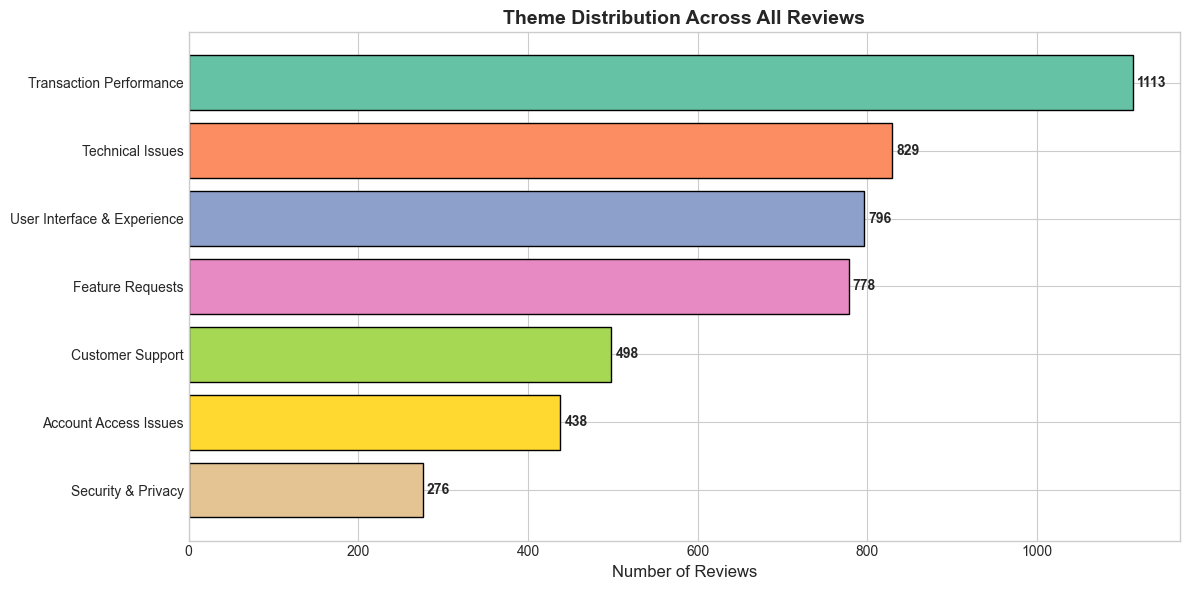

In [16]:
# Overall theme distribution
all_themes = []
for themes in df_final['themes']:
    if isinstance(themes, list):
        all_themes.extend(themes)
    elif isinstance(themes, str):
        # Handle string representation of list
        import ast
        try:
            all_themes.extend(ast.literal_eval(themes))
        except:
            pass

theme_counts = Counter(all_themes)

fig, ax = plt.subplots(figsize=(12, 6))

themes = [t[0] for t in theme_counts.most_common()]
counts = [t[1] for t in theme_counts.most_common()]

colors = sns.color_palette('Set2', len(themes))
bars = ax.barh(themes, counts, color=colors, edgecolor='black')

# Add count labels
for bar, count in zip(bars, counts):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
            str(count), va='center', fontweight='bold')

ax.set_xlabel('Number of Reviews', fontsize=12)
ax.set_title('Theme Distribution Across All Reviews', fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Most common at top

plt.tight_layout()
plt.savefig('../data/processed/theme_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Themes by Bank

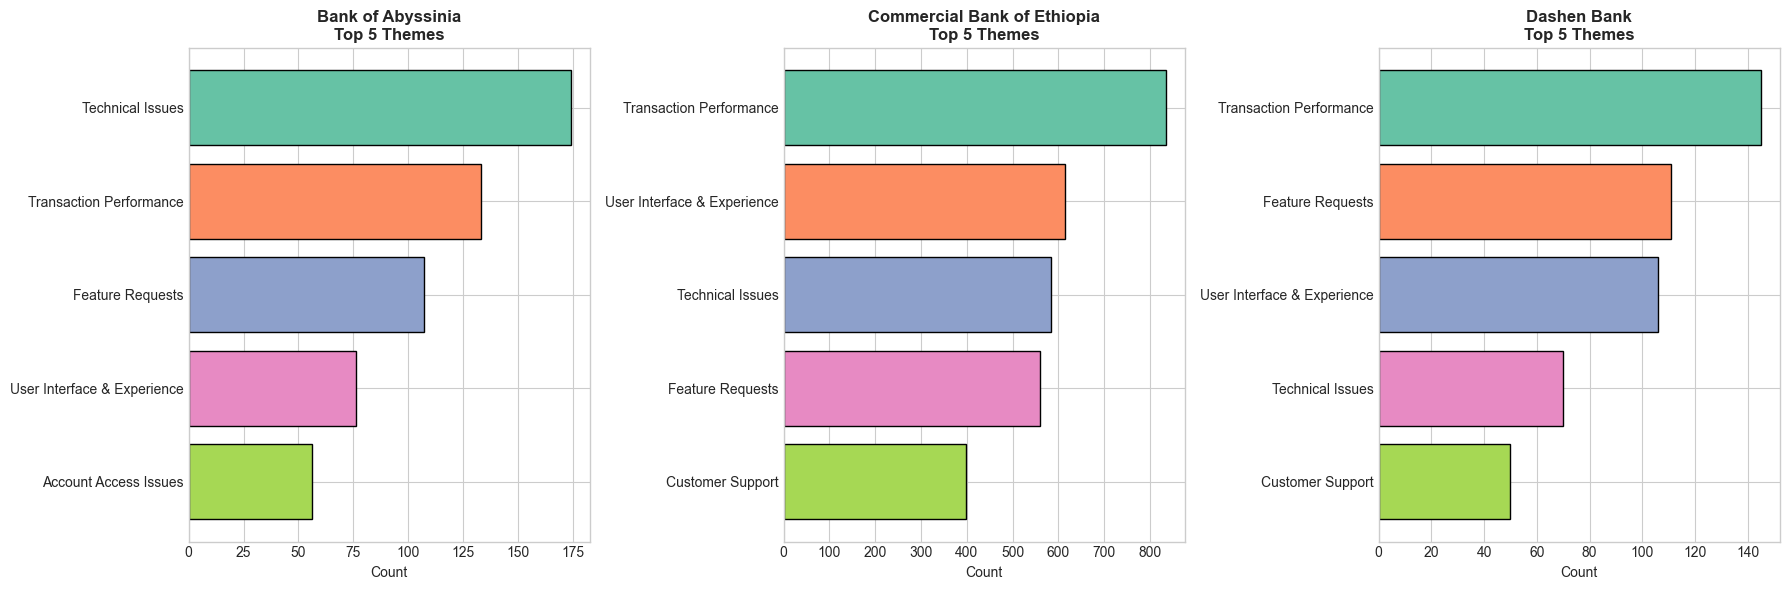

In [17]:
# Theme distribution by bank
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, bank in enumerate(df_final['bank_name'].unique()):
    ax = axes[idx]
    bank_df = df_final[df_final['bank_name'] == bank]
    
    bank_themes = []
    for themes in bank_df['themes']:
        if isinstance(themes, list):
            bank_themes.extend(themes)
        elif isinstance(themes, str):
            import ast
            try:
                bank_themes.extend(ast.literal_eval(themes))
            except:
                pass
    
    if bank_themes:
        bank_theme_counts = Counter(bank_themes).most_common(5)
        themes = [t[0] for t in bank_theme_counts]
        counts = [t[1] for t in bank_theme_counts]
        
        ax.barh(themes, counts, color=sns.color_palette('Set2', len(themes)), edgecolor='black')
        ax.set_xlabel('Count')
        ax.set_title(f'{bank}\nTop 5 Themes', fontsize=12, fontweight='bold')
        ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../data/processed/themes_by_bank.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Theme-Sentiment Correlation

**Key Insight:** Which themes are associated with positive vs negative sentiment?

In [18]:
# Calculate theme-sentiment correlation
correlation_df = theme_analyzer.get_theme_sentiment_correlation(df_final)


Theme-Sentiment Correlation:
------------------------------------------------------------
  👍 Account Access Issues:
      Positive: 57.5% | Negative: 26.7%
  👍 Transaction Performance:
      Positive: 54.9% | Negative: 24.1%
  👍 User Interface & Experience:
      Positive: 77.1% | Negative: 16.3%
  👎 Technical Issues:
      Positive: 34.3% | Negative: 43.9%
  👍 Customer Support:
      Positive: 70.1% | Negative: 22.1%
  👍 Feature Requests:
      Positive: 67.9% | Negative: 20.2%
  👍 Security & Privacy:
      Positive: 68.5% | Negative: 18.8%


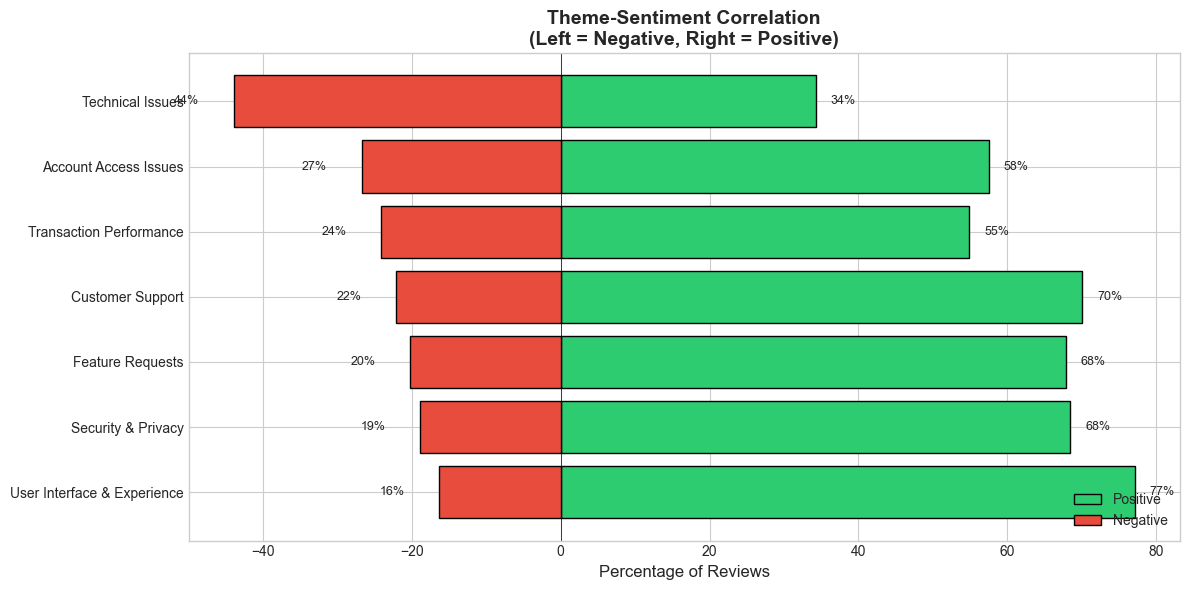

In [19]:
# Visualize theme-sentiment correlation
if correlation_df is not None and len(correlation_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Sort by negative percentage (pain points first)
    correlation_df = correlation_df.sort_values('negative_pct', ascending=True)
    
    themes = correlation_df['theme']
    pos_pct = correlation_df['positive_pct']
    neg_pct = correlation_df['negative_pct']
    
    y_pos = range(len(themes))
    
    # Create horizontal bar chart
    ax.barh(y_pos, pos_pct, color='#2ecc71', label='Positive', edgecolor='black')
    ax.barh(y_pos, -neg_pct, color='#e74c3c', label='Negative', edgecolor='black')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(themes)
    ax.set_xlabel('Percentage of Reviews', fontsize=12)
    ax.set_title('Theme-Sentiment Correlation\n(Left = Negative, Right = Positive)', 
                 fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.legend(loc='lower right')
    
    # Add percentage labels
    for i, (p, n) in enumerate(zip(pos_pct, neg_pct)):
        ax.text(p + 2, i, f'{p:.0f}%', va='center', fontsize=9)
        ax.text(-n - 8, i, f'{n:.0f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../data/processed/theme_sentiment_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Key Insights

In [20]:
# Generate key insights
print("=" * 60)
print("KEY INSIGHTS FROM SENTIMENT & THEMATIC ANALYSIS")
print("=" * 60)

# 1. Overall sentiment
total = len(df_final)
pos_total = len(df_final[df_final['sentiment_label_distilbert'] == 'POSITIVE'])
neg_total = len(df_final[df_final['sentiment_label_distilbert'] == 'NEGATIVE'])

print(f"\n1. OVERALL SENTIMENT")
print(f"   Total reviews analyzed: {total}")
print(f"   Positive: {pos_total} ({pos_total/total*100:.1f}%)")
print(f"   Negative: {neg_total} ({neg_total/total*100:.1f}%)")

# 2. Best and worst performing bank
print(f"\n2. BANK COMPARISON")
bank_scores = {}
for bank in df_final['bank_name'].unique():
    bank_df = df_final[df_final['bank_name'] == bank]
    pos = len(bank_df[bank_df['sentiment_label_distilbert'] == 'POSITIVE'])
    bank_scores[bank] = pos / len(bank_df) * 100

best_bank = max(bank_scores, key=bank_scores.get)
worst_bank = min(bank_scores, key=bank_scores.get)

print(f"   Best satisfaction: {best_bank} ({bank_scores[best_bank]:.1f}% positive)")
print(f"   Needs improvement: {worst_bank} ({bank_scores[worst_bank]:.1f}% positive)")

# 3. Top pain points (themes with highest negative %)
print(f"\n3. TOP PAIN POINTS (Themes with most negative reviews)")
if correlation_df is not None:
    pain_points = correlation_df.nlargest(3, 'negative_pct')
    for _, row in pain_points.iterrows():
        print(f"   - {row['theme']}: {row['negative_pct']:.1f}% negative")

# 4. Satisfaction drivers (themes with highest positive %)
print(f"\n4. SATISFACTION DRIVERS (Themes with most positive reviews)")
if correlation_df is not None:
    drivers = correlation_df.nlargest(3, 'positive_pct')
    for _, row in drivers.iterrows():
        print(f"   - {row['theme']}: {row['positive_pct']:.1f}% positive")

KEY INSIGHTS FROM SENTIMENT & THEMATIC ANALYSIS

1. OVERALL SENTIMENT
   Total reviews analyzed: 7290
   Positive: 4199 (57.6%)
   Negative: 3091 (42.4%)

2. BANK COMPARISON
   Best satisfaction: Dashen Bank (70.0% positive)
   Needs improvement: Bank of Abyssinia (38.1% positive)

3. TOP PAIN POINTS (Themes with most negative reviews)
   - Technical Issues: 43.9% negative
   - Account Access Issues: 26.7% negative
   - Transaction Performance: 24.1% negative

4. SATISFACTION DRIVERS (Themes with most positive reviews)
   - User Interface & Experience: 77.1% positive
   - Customer Support: 70.1% positive
   - Security & Privacy: 68.5% positive


## 6. Sample Reviews by Theme

In [21]:
# Show sample reviews for top themes
print("Sample Reviews by Theme")
print("=" * 60)

for theme in list(THEME_KEYWORDS.keys())[:4]:  # Top 4 themes
    print(f"\n{theme}")
    print("-" * 40)
    
    # Find reviews with this theme
    theme_reviews = df_final[df_final['primary_theme'] == theme]
    
    if len(theme_reviews) > 0:
        # Show one positive and one negative
        pos_review = theme_reviews[theme_reviews['sentiment_label_distilbert'] == 'POSITIVE'].head(1)
        neg_review = theme_reviews[theme_reviews['sentiment_label_distilbert'] == 'NEGATIVE'].head(1)
        
        if len(pos_review) > 0:
            print(f"  [POSITIVE] \"{pos_review['review_text'].values[0][:150]}...\"")
        if len(neg_review) > 0:
            print(f"  [NEGATIVE] \"{neg_review['review_text'].values[0][:150]}...\"")
    else:
        print("  No reviews found for this theme.")

Sample Reviews by Theme

Account Access Issues
----------------------------------------
  [POSITIVE] "This the best mobile banking App BOA mobile banking included all digital banking features and we can access the most companies and sectors with this A..."
  [NEGATIVE] "It does not show the name of the person who sent the money to request a receipt. This has become very difficult for us. When different people transfer..."

Transaction Performance
----------------------------------------
  [POSITIVE] "fast and simple..."
  [NEGATIVE] "when trying to activate the app it keeps on loading on the security questions page. It has been two days..."

User Interface & Experience
----------------------------------------
  [POSITIVE] "Nice app and it's easy to use..."
  [NEGATIVE] "It keeps notifying me to disable developer options and quiet while I'm not enabled. always bring another type of problem with new updates...."

Technical Issues
----------------------------------------
  [POSITIVE] "Nic

## 7. Save Results

In [22]:
# Save final results with sentiment and themes
output_path = '../data/processed/reviews_with_sentiment_themes.csv'
df_final.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

# Show final columns
print(f"\nFinal dataset columns:")
for col in df_final.columns:
    print(f"  - {col}")

Results saved to ../data/processed/reviews_with_sentiment_themes.csv

Final dataset columns:
  - review_id
  - review_text
  - rating
  - review_date
  - review_year
  - review_month
  - bank_code
  - bank_name
  - user_name
  - thumbs_up
  - text_length
  - source
  - sentiment_label_vader
  - sentiment_score_vader
  - sentiment_label_distilbert
  - sentiment_score_distilbert
  - themes
  - primary_theme
  - matched_keywords
  - tfidf_keywords


In [23]:
# Final dataset preview
df_final[['bank_name', 'review_text', 'rating', 'sentiment_label_distilbert', 'primary_theme']].head(10)

,bank_name,review_text,rating,sentiment_label_distilbert,primary_theme
0,Bank of Abyssinia,very good,5,POSITIVE,Other
1,Bank of Abyssinia,most of the time is not working properly,1,NEGATIVE,Technical Issues
2,Bank of Abyssinia,good service,5,POSITIVE,Customer Support
3,Bank of Abyssinia,not use for me,3,NEGATIVE,Other
4,Bank of Abyssinia,It keeps notifying me to disable developer options and quiet while I'm not enabled. always bring...,1,NEGATIVE,User Interface & Experience
5,Bank of Abyssinia,waw,5,NEGATIVE,Other
6,Bank of Abyssinia,the lag is unbelievable when you need it the most this suks,1,NEGATIVE,Feature Requests
7,Bank of Abyssinia,I cant belive I could find the worst bank app ever .yet very simple to fix the problem and the c...,1,NEGATIVE,Technical Issues
8,Bank of Abyssinia,it is a good app,5,POSITIVE,Other
9,Bank of Abyssinia,it is not working at all,1,NEGATIVE,Technical Issues


## 8. Task 2 Summary

### Completed:
- ✅ Sentiment analysis using VADER (rule-based)
- ✅ Sentiment analysis using DistilBERT (transformer-based)
- ✅ Comparison of both methods
- ✅ Thematic analysis with TF-IDF keyword extraction
- ✅ Theme-sentiment correlation analysis
- ✅ Visualizations for all analyses

### Key Deliverables:
- Sentiment scores for all reviews (90%+ coverage)
- 3+ themes identified per bank
- Pain points and satisfaction drivers identified

### Next Steps (Task 3):
- Store results in PostgreSQL database
- Create database schema for reviews, sentiment, and themes